Install MONAI for this notebook

In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


Imports

In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import PIL

MONAI imports

In [4]:
import torch
import monai

In [5]:
from monai.config import print_config
print_config()

MONAI version: 0.6.0
Numpy version: 1.24.1
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Setup data directory

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
%env DATA_DIRECTORY = /content/drive/My Drive/data_dir

env: DATA_DIRECTORY=/content/drive/My Drive/data_dir


In [ ]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/My Drive/data_dir


In [ ]:
from monai.apps import download_and_extract

In [ ]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
resource = "https://scholar.cu.edu.eg/Dataset_BUSI.zip"

compressed_file = os.path.join(root_dir, "Dataset_BUSI.zip")
data_dir = os.path.join(root_dir, "Dataset_BUSI_with_GT")
if not os.path.exists(data_dir):
  download_and_extract(resource, compressed_file, root_dir)

In [ ]:
from monai.utils import set_determinism
set_determinism(seed=0)

Resize the datasets

In [ ]:
import cv2
new_path = os.path.join(root_dir, "Resized_Dataset")
image_size=512
if not os.path.exists(new_path):
  os.mkdir(new_path)
  for i, folder in enumerate (os.listdir(data_dir)): 
    for img  in  os.listdir(os.path.join(data_dir, folder)):
      if '.png' in img:
          # continue
          image = cv2.imread(data_dir+'/'+folder+'/'+img)  
          image = cv2.resize(image,(image_size,image_size))
          if '_mask' in img:
              image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          if not os.path.exists(os.path.join(new_path, folder)):
            os.mkdir(os.path.join(new_path, folder))
          cv2.imwrite(new_path+'/'+folder+'/'+img, image)

Some basics about the dataset

In [ ]:
data_dir = new_path
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
        if 'mask' not in x
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
  image_files_list.extend(image_files[i])
  image_class.extend([i] * num_each[i])

num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total Image Count: {num_total}")
print(f"Image Dimensions: {image_width} x {image_height}")
print(f"Label Names: {class_names}")
print(f"Label counts: {num_each}")

Total Image Count: 780
Image Dimensions: 512 x 512
Label Names: ['benign', 'malignant', 'normal']
Label counts: [437, 210, 133]


Pick images to visualize

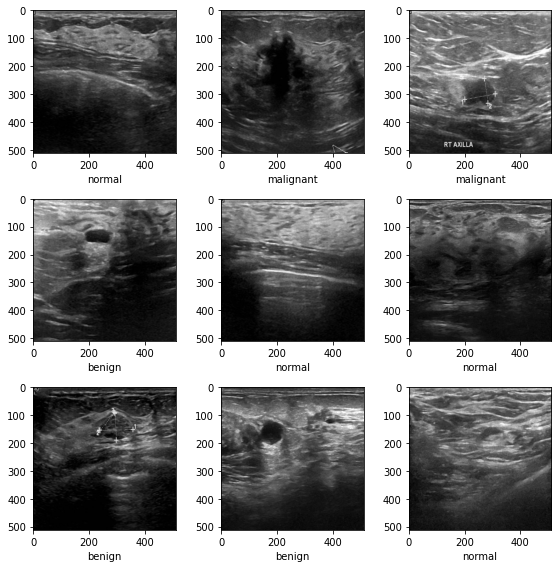

In [ ]:
plt.subplots(3, 3, figsize=(8,8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
  im = PIL.Image.open(image_files_list[k])
  arr = np.array(im)
  plt.subplot(3, 3, i+1)
  plt.xlabel(class_names[image_class[k]])
  plt.imshow(arr, cmap="gray", vmin=0, vmax=255)

plt.tight_layout()
plt.show()

Partition the data into training, validation and test

In [ ]:
from monai.data import partition_dataset_classes
train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)), image_class, (8.5, 1, 0.5), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
train_mask = [image_files_list[i].replace('.png', '_mask.png') for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
val_mask = [image_files_list[i].replace('.png', '_mask.png') for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]
test_mask = [image_files_list[i].replace('.png', '_mask.png') for i in test_inds]

print(f"Training Count: {len(train_x)}, Validation Count: {len(val_x)}, Test Count: {len(test_x)}")
print(f"Training samples of type normal {sum(1 for s in train_mask if 'normal' in s)}")
print(f"Training samples of type benign {sum(1 for s in train_mask if 'benign' in s)}")
print(f"Training samples of type malignant {sum(1 for s in train_mask if 'malignant' in s)}")

Training Count: 663, Validation Count: 78, Test Count: 39


In [ ]:
print(train_x[0])
print(train_mask[0])

/content/drive/My Drive/data_dir/Resized_Dataset/malignant/malignant (4).png
/content/drive/My Drive/data_dir/Resized_Dataset/malignant/malignant (4)_mask.png


Build a Data Dictionary for UNET

In [ ]:
train_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_x, train_mask)]
val_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_x, val_mask)]
test_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_x, test_mask)]

Build the Transforms: 
1. Resize all images to the same dimensions
2. Scale Intensity to between 0 and 1
3. Add a Channel Dimension first

In [ ]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Resized,
    EnsureTyped
)

train_transforms = Compose(
    [
    LoadImaged(keys=["image", "label"]),
#    Resized(keys=["image", "label"], spatial_size=(500,500)),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"])
    ]
)

val_transforms = Compose(
    [
    LoadImaged(keys=["image", "label"]),
#    Resized(keys=["image", "label"], spatial_size=(500, 500)),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"])
    ]
)

Set up the Data Loader. USe a cached dataset to have the images in the cache once loaded

In [ ]:
from monai.data import CacheDataset, DataLoader
train_ds = CacheDataset(data=train_dicts, transform=train_transforms, cache_rate=1.0, num_workers=10)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_dicts, transform=val_transforms, cache_rate=1.0, num_workers=10)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

test_ds = CacheDataset(data=test_dicts, transform=val_transforms, cache_rate=1.0, num_workers=10)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████| 663/663 [00:09<00:00, 67.63it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 39/39 [00:00<00:00, 67.64it/s]


Build the UNET Model now

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device =torch.device("cuda:0")
model = UNet(
    dimensions = 2,
    in_channels = 3,
    out_channels = 3,
    channels = (16, 32, 64, 128, 256, 512),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm=Norm.BATCH
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax = True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Train the Model

In [ ]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=3)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=3)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/331, train_loss: 0.7598
2/331, train_loss: 0.8177
3/331, train_loss: 0.7909
4/331, train_loss: 0.7960
5/331, train_loss: 0.7784
6/331, train_loss: 0.8096
7/331, train_loss: 0.8114
8/331, train_loss: 0.7908
9/331, train_loss: 0.7943
10/331, train_loss: 0.8100
11/331, train_loss: 0.7882
12/331, train_loss: 0.8018
13/331, train_loss: 0.8105
14/331, train_loss: 0.7755
15/331, train_loss: 0.8096
16/331, train_loss: 0.7761
17/331, train_loss: 0.7793
18/331, train_loss: 0.7932
19/331, train_loss: 0.7703
20/331, train_loss: 0.7836
21/331, train_loss: 0.7969
22/331, train_loss: 0.7918
23/331, train_loss: 0.7808
24/331, train_loss: 0.7753
25/331, train_loss: 0.7995
26/331, train_loss: 0.7863
27/331, train_loss: 0.7828
28/331, train_loss: 0.8048
29/331, train_loss: 0.7704
30/331, train_loss: 0.7703
31/331, train_loss: 0.7861
32/331, train_loss: 0.7882
33/331, train_loss: 0.7737
34/331, train_loss: 0.7809
35/331, train_loss: 0.7699
36/331, train_loss: 0.7309
37/331, train_lo

Loss and Dice 

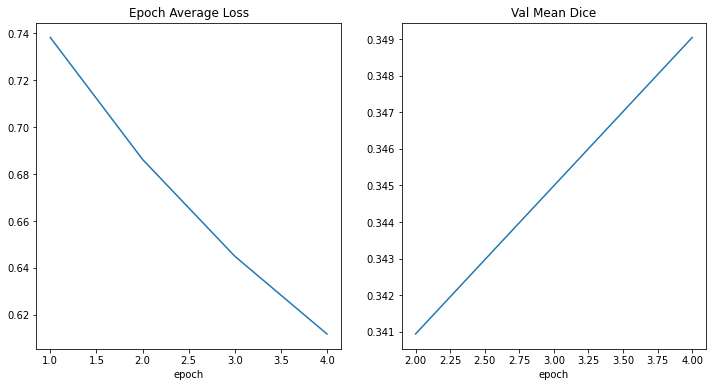

In [ ]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Inference on test

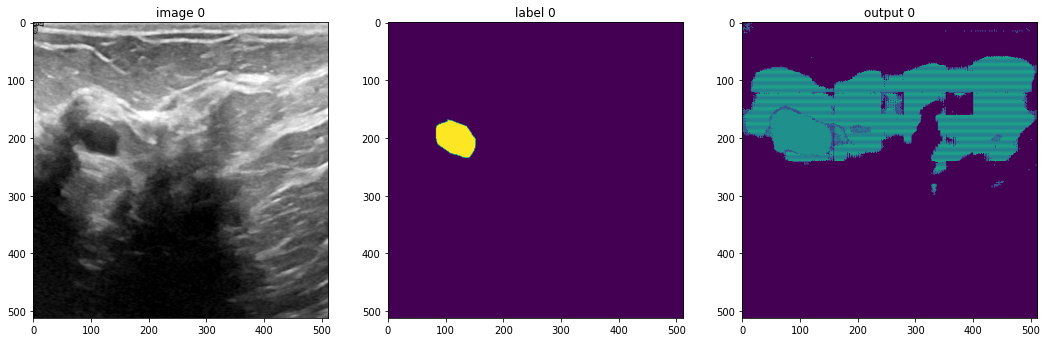

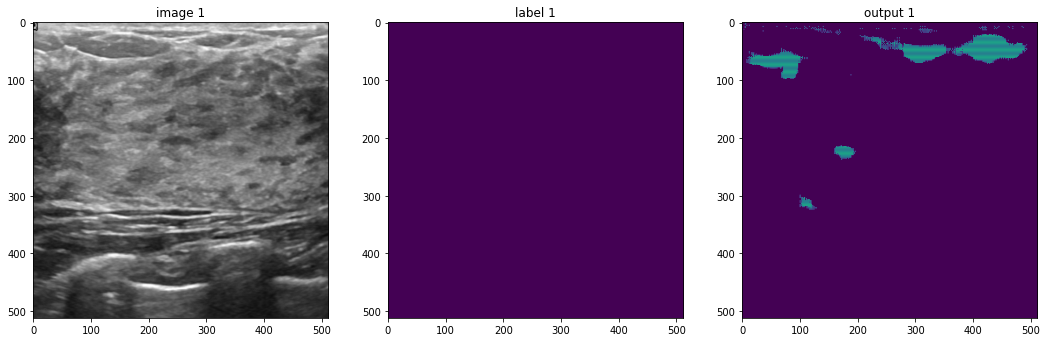

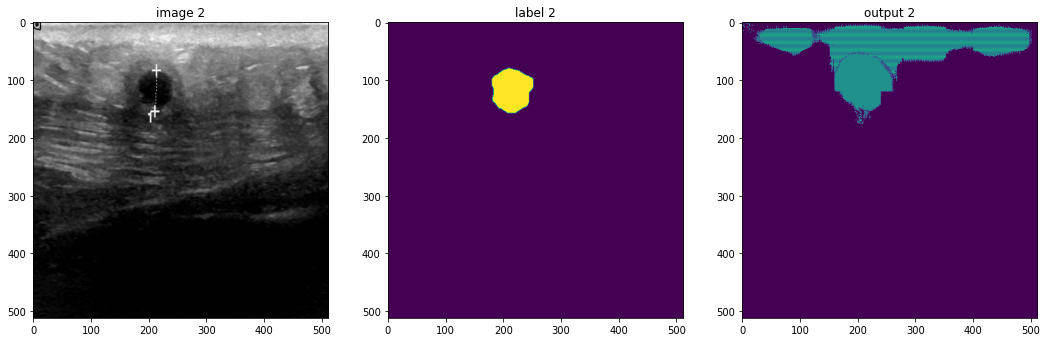

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :])
        plt.show()
        if i == 2:
            break